# Dataset overview

In [1]:
import myUtils
import pandas as pd
import numpy as np
from pandas.io.json._normalize import nested_to_record
import matplotlib.pyplot as plt
import re
import nltk

**Load dataset**

In [2]:
review_dict = myUtils.read_json_v2('data/reviews_revision.json')
reviews = pd.DataFrame.from_dict(nested_to_record(review_dict, sep='_'))
reviews.drop(columns='_id_$oid', inplace=True)

**Calculate token count per review**

In [3]:
reviews['tokens'] = reviews['text'].apply(nltk.word_tokenize)
reviews['token_count'] = reviews['tokens'].apply(len)

In [4]:
reviews.sample(5)

,text,meta_product_name,meta_product_type,meta_review_sentiment,meta_review_pros,meta_review_so-so,meta_review_cons,tokens,token_count
738,Αν δεν υπήρχαν τόσοι fans του Κοτζιμα δεν θα γ...,Death Stranding PS4,PS4 Games,negative,[],[],[Αντοχή στο χρόνο],"[Αν, δεν, υπήρχαν, τόσοι, fans, του, Κοτζιμα, ...",53
9,"πολυ μετριο κινητο, το αγορασα πριν εναν μηνα ...",Samsung Galaxy A20e Dual (32GB) Black,Κινητά Τηλέφωνα,negative,[],[],"[Ταχύτητα, Μπαταρία]","[πολυ, μετριο, κινητο, ,, το, αγορασα, πριν, ε...",134
411,Κάτοχος του συγκεκριμένου κινητού εδώ και δύο ...,Xiaomi Poco X3 NFC (128GB) Shadow Gray,Κινητά Τηλέφωνα,neutral,[Μπαταρία],[],"[Φωτογραφίες, Ταχύτητα, Καταγραφή Video]","[Κάτοχος, του, συγκεκριμένου, κινητού, εδώ, κα...",66
67,Δεν αξίζει δεν έχει σχεδόν τίποτα καλό αν είχε...,Samsung Galaxy A32 5G (64GB) Black,Κινητά Τηλέφωνα,negative,"[Οθόνη, Μπαταρία]",[],"[Σχέση ποιότητας τιμής, Ταχύτητα, Φωτογραφίες,...","[Δεν, αξίζει, δεν, έχει, σχεδόν, τίποτα, καλό,...",36
248,Πρωταρης στη σειρα souls και πολυ ασχημη εμπει...,Bloodborne (Game of The Year) PS4,PS4 Games,neutral,[Γραφικά],[Αντοχή στο χρόνο],[Single Player],"[Πρωταρης, στη, σειρα, souls, και, πολυ, ασχημ...",60


**Remove outliers (entries with very long length)**

In [5]:
reviews = reviews[reviews['token_count'] <= 256].reset_index(drop=True)

In [6]:
len(reviews[reviews['token_count'] <= 200]) / len(reviews)

0.9610091743119266

**Plot sentiment distribution**

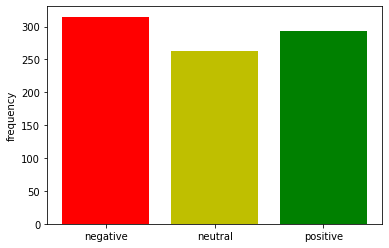

In [7]:
labels = reviews['meta_review_sentiment'].unique()
labels = sorted(labels)
label_count = []
for l in labels:
    label_count.append(len(reviews[reviews['meta_review_sentiment'] == l]))

plt.bar(labels, label_count, color=['r','y','g'])
plt.ylabel('frequency')
plt.show()

**Plot review token count**

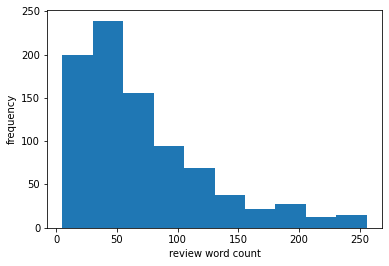

In [8]:
plt.hist(reviews['token_count'])
plt.xlabel('review word count')
plt.ylabel('frequency')
plt.show()

In [9]:
reviews['token_count'].describe()

count    872.000000
mean      70.432339
std       54.165393
min        5.000000
25%       32.000000
50%       55.000000
75%       95.000000
max      256.000000
Name: token_count, dtype: float64

**Plot review product type distribution**

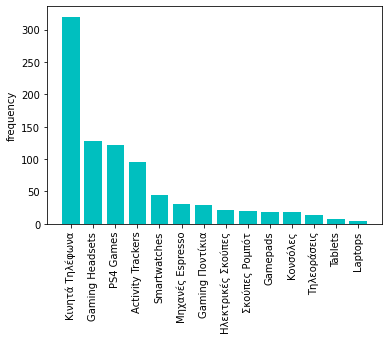

In [10]:
types = reviews['meta_product_type'].unique()
type_count = []
for t in types:
    type_count.append(len(reviews[reviews['meta_product_type'] == t]))
    
sorted_idx = np.argsort(type_count)[::-1]
types = types[sorted_idx]
type_count = np.array(type_count)[sorted_idx] 

plt.bar(types, type_count, color='c')
plt.xticks(rotation='vertical')
plt.ylabel('frequency')
plt.show()

**Find distinct labels and calculate aspect label occurance**

In [11]:
labels = []
label_freq = []
pros_label_freq = []
so_so_label_freq = []
cons_label_freq = []
total_reviews = []

for t in types:
    # create list of all labels of certain type
    pros_list = [item for sublist in reviews.loc[reviews['meta_product_type'] == t, 'meta_review_pros']
                      for item in sublist]
    so_so_list = [item for sublist in reviews.loc[reviews['meta_product_type'] == t, 'meta_review_so-so']
                       for item in sublist]
    cons_list = [item for sublist in reviews.loc[reviews['meta_product_type'] == t, 'meta_review_cons']
                      for item in sublist]
    
    # find distinct labels
    labels_temp = set.union(
        set(pros_list),
        set(so_so_list),
        set(cons_list)
    )
    # append results to list
    for l in labels_temp:
        total_reviews.append(len(reviews.loc[reviews['meta_product_type'] == t]))
        labels.append((t + '#' + l).replace(" ", "_"))
        
        pros_count = pros_list.count(l)
        so_so_count = so_so_list.count(l)
        cons_count = cons_list.count(l)
        total_count = pros_count + so_so_count + cons_count
        pros_label_freq.append(pros_count / total_count * 100)
        so_so_label_freq.append(so_so_count / total_count * 100)
        cons_label_freq.append(cons_count / total_count * 100)
        label_freq.append(total_count / total_reviews[-1] * 100)

In [12]:
def set_color(col):
    '''Function to set color of dataframe cells'''
    
    if col.name == 'Positive' or col.name == 'Neutral' or col.name == 'Negative':
        return ['background-color: rgba(0,45,255,' + str(c/100) + ')' for c in col.values]
    if col.name == 'Occurence':
        return ['background-color: rgba(0,150,0,' + str(c/50 - 0.9) + ')' if c > 50 else
                'background-color: rgba(240,12,19,' + str(1 - c/50) + ')'
                for c in col.values]
    else:
        return ['' for c in col.values]

**Plot results**  
<span style="color:green">Green color</span> represents occurance of label in more than half of reviews and vice versa for <span style="color:red">red color</span>.<br>
<span style="color:blue">Blue color</span> represents the frequency of each sentiment in reviews that the label exists.

In [13]:
stats = pd.DataFrame(data={
    'Label': labels,
    'Occurence': label_freq,
    'Positive': pros_label_freq,
    'Neutral': so_so_label_freq,
    'Negative': cons_label_freq,
    'Total reviews': total_reviews
})

stats.style.format('{:.2f}%', subset=['Occurence', 'Positive', 'Neutral', 'Negative']).apply(set_color, axis=0)

,Label,Occurence,Positive,Neutral,Negative,Total reviews
0,Κινητά_Τηλέφωνα#Οθόνη,34.06%,62.39%,21.10%,16.51%,320
1,Κινητά_Τηλέφωνα#Σχέση_ποιότητας_τιμής,56.25%,48.89%,15.00%,36.11%,320
2,Κινητά_Τηλέφωνα#Καταγραφή_Video,36.88%,55.08%,21.19%,23.73%,320
3,Κινητά_Τηλέφωνα#Ταχύτητα,62.19%,39.20%,14.07%,46.73%,320
4,Κινητά_Τηλέφωνα#Φωτογραφίες,46.25%,56.08%,21.62%,22.30%,320
5,Κινητά_Τηλέφωνα#Ποιότητα_κλήσης,21.56%,24.64%,21.74%,53.62%,320
6,Κινητά_Τηλέφωνα#GPS,0.31%,100.00%,0.00%,0.00%,320
7,Κινητά_Τηλέφωνα#Μπαταρία,46.88%,56.67%,16.67%,26.67%,320
8,Κινητά_Τηλέφωνα#Ηχείο,26.88%,46.51%,26.74%,26.74%,320
9,Gaming_Headsets#Ποιότητα_κατασκευής,51.56%,27.27%,13.64%,59.09%,128


**Write top labels to txt file for model training**

In [14]:
# with open('GloVe_models/top_labels.txt', 'w', encoding='utf-8') as f:
#     for i in stats[(stats['Total reviews'] > 90) & (stats['Occurence'] > 35)]['Label'].values:
#         f.write(i + '\n')

In [15]:
labels = []
label_freq = []
pros_label_freq = []
so_so_label_freq = []
cons_label_freq = []
total_reviews = []

for t in types:
    # create list of all labels of certain type
    pros_list = [item for sublist in reviews.loc[reviews['meta_product_type'] == t, 'meta_review_pros']
                      for item in sublist]
    so_so_list = [item for sublist in reviews.loc[reviews['meta_product_type'] == t, 'meta_review_so-so']
                       for item in sublist]
    cons_list = [item for sublist in reviews.loc[reviews['meta_product_type'] == t, 'meta_review_cons']
                      for item in sublist]
    
    # find distinct labels
    labels_temp = set.union(
        set(pros_list),
        set(so_so_list),
        set(cons_list)
    )
    # append results to list
    for l in labels_temp:
        total_reviews.append(len(reviews.loc[reviews['meta_product_type'] == t]))
        labels.append((t + '#' + l).replace(" ", "_"))
        
        pros_count = pros_list.count(l)
        so_so_count = so_so_list.count(l)
        cons_count = cons_list.count(l)
        total_count = pros_count + so_so_count + cons_count
        pros_label_freq.append(pros_count)
        so_so_label_freq.append(so_so_count)
        cons_label_freq.append(cons_count)
        label_freq.append(total_count)

In [16]:
stats = pd.DataFrame(data={
    'Label': labels,
    'Occurence': label_freq,
    'Positive': pros_label_freq,
    'Neutral': so_so_label_freq,
    'Negative': cons_label_freq,
    'Total reviews': total_reviews
})

stats.sort_values('Occurence', ascending=False).drop(columns=['Occurence']).style.format('{:}')

,Label,Positive,Neutral,Negative,Total reviews
3,Κινητά_Τηλέφωνα#Ταχύτητα,78,28,93,320
1,Κινητά_Τηλέφωνα#Σχέση_ποιότητας_τιμής,88,27,65,320
7,Κινητά_Τηλέφωνα#Μπαταρία,85,25,40,320
4,Κινητά_Τηλέφωνα#Φωτογραφίες,83,32,33,320
2,Κινητά_Τηλέφωνα#Καταγραφή_Video,65,25,28,320
0,Κινητά_Τηλέφωνα#Οθόνη,68,23,18,320
8,Κινητά_Τηλέφωνα#Ηχείο,40,23,23,320
21,PS4_Games#Gameplay,26,18,41,121
18,PS4_Games#Αντοχή_στο_χρόνο,27,11,45,121
20,PS4_Games#Single_Player,32,15,28,121
